# Laboratory exercise 3
> Håvard Godal, 245609

## Problem 1
> The tasks are restructured to create a cleaner code and are mentioned throughout the notebook.

#### Importing numpy, creating the priors, and creating the matrices $X_1$ and $X_2$

In [1]:
import numpy as np
from pdffuns import norm2D, knn2D, classplot

In [2]:
import pickle

pfile = 'lab3.p'
with open(pfile, 'rb') as fp:
    X = pickle.load(fp)

In [3]:
numX1 = len(X[0][0])
numX2 = len(X[1][0])
N = [numX1, numX2]
numTot = numX1 + numX2

In [4]:
Pw = np.array([numX1/numTot, numX2/numTot])

M = len(X)

In [5]:
x1 = np.linspace(start=-5, stop=10, num=25).reshape(-1, 1)
x2 = np.linspace(start=-5, stop=10, num=25).reshape(-1, 1)

X1, X2 = np.meshgrid(x1, x2)

#### Creating the main function to generate $p(x)$.

In [6]:
def labsol3(type='ML', title='', prm=1):
    pxw = []
    px = 0

    if type == 'ML':
        # Subtask a) and b)
        my = []
        Sgm = []
        for dataset in X:
            my.append(np.mean(dataset, 1))
            Sgm.append(np.cov(dataset))

        for i in range(M):
            pxw.append(norm2D(my[i], Sgm[i], X1, X2))
            px += Pw[i] * pxw[i]
        overlapping = [True, False]
    elif type == 'PZ':
        for i in range(M):
            h1 = prm

            hn = h1 / np.sqrt(N[i])
            hnI = hn**2 * np.eye(M)

            pns = []
            for j in range(N[i]):
                pns.append(norm2D(X[i][:, j], hnI, X1, X2))
            pxw.append(1/N[i] * np.sum(pns, axis=0))
            px += Pw[i] * pxw[i]
        overlapping = [True, False]
    elif type == 'KN':
        for i in range(M):
            knn = prm

            pxw.append(knn2D(X[i], knn, X1, X2))
            px += Pw[i] * pxw[i]
        overlapping = [True, True]

    g1 = []
    g2 = []
    for j in range(M):
        g1.append(Pw[j] * pxw[j])  # scaled class-conditional
        g2.append((pxw[j] * Pw[j]) / px)  # posterior

    classplot([g1, g2], X1, X2, overlapping, title)

#### c) + d) for the maximum likelihood classification.

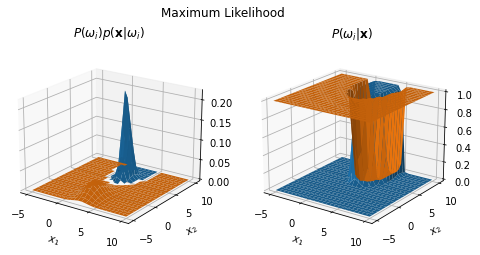

In [7]:
labsol3('ML', 'Maximum Likelihood')

#### e)

The decision boundary is marked by a tiny white line separating the two colors, and the decision areas are indicated by the different colors.

$Red = \omega_1$ and $blue = \omega_2$.

#### c) + d) for the Parzen classifier with window size $h_1 = 0.5$.

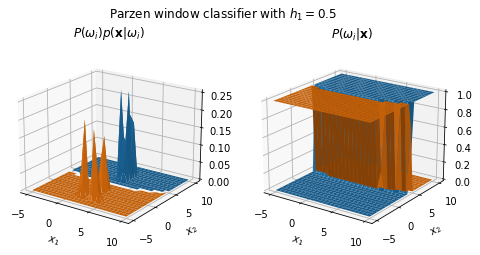

In [8]:
labsol3('PZ', ('Parzen window classifier with ' + r'$h_1 = 0.5$'), 0.5)

#### c) + d) for the Parzen classifier with window size $h_1 = 5.0$.

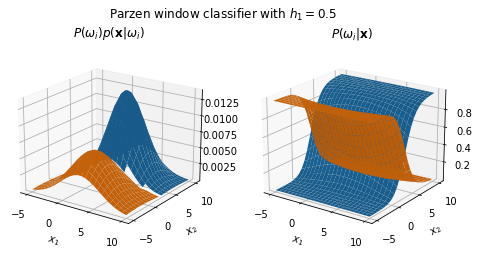

In [9]:
labsol3('PZ', ('Parzen window classifier with ' + r'$h_1 = 0.5$'), 5.0)

#### c) + d) for the knn-classifier with $k_n = 1$.

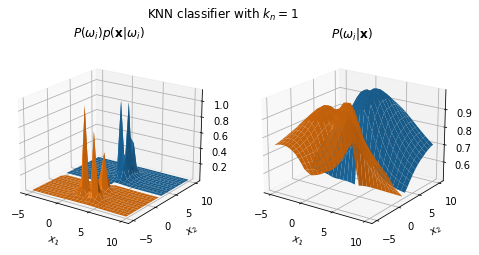

In [10]:
labsol3('KN', ('KNN classifier with ' + r'$k_n = 1$'), 1)

#### c) + d) for the knn-classifier with $k_n = 3$.

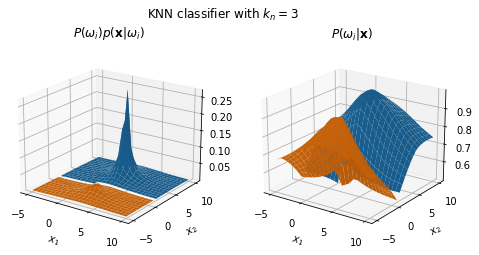

In [11]:
labsol3('KN', ('KNN classifier with ' + r'$k_n = 3$'), 3)

#### c) + d) for the knn-classifier with $k_n = 5$.

Calculating the knn-classifier with $k_n = 5$ would not work as there is not enough data points. Because we only have 4 and 3 datapoints in each data set $\chi_i$, finding the 5th nearest neighbour is not possible.

#### The following is the content of `pdffuns.py`

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def norm1D(my, Sgm, x):
    p = np.zeros(np.shape(x))
    n, _ = np.shape(x)

    const = 1 / (np.sqrt(2 * np.pi) * Sgm)

    for i in range(n):
        p[i] = const * \
            np.exp(-1 / 2 * np.square((x[i] - my)) / (np.square(Sgm)))

    return p


def norm2D(my, sigma, X1, X2):
    p = np.zeros(np.shape(X1))
    dim1, dim2 = np.shape(X1)

    const = (2*np.pi)**(-len(my)/2) * (np.linalg.det(sigma))**(-1/2)

    for i in range(dim1):
        for j in range(dim2):
            x_mu = ([X1[i, j], X2[i, j]] - my)
            p[i, j] = const * \
                np.exp(-1/2 * np.linalg.multi_dot([
                    x_mu.T,
                    np.linalg.inv(sigma),
                    x_mu
                ]))
    return p


def knn2D(data, kn, X1, X2):
    p = np.zeros(np.shape(X1))
    dim1, dim2 = np.shape(X1)

    n = len(data[0])
    distances = []

    for i in range(n):
        my = data[:, i]
        distances.append(np.sqrt((X1 - my[0])**2 + (X2 - my[1])**2))

    for i in range(dim1):
        for j in range(dim2):
            distpoints = [distance[i][j] for distance in distances]
            idx = np.argsort(distpoints, 0)
            r = distpoints[idx[kn-1]]
            V = np.pi * r**2
            p[i, j] = kn / (n*V)

    return p


def classplot(every_g, X1, X2, overlappings=[True, False], title=''):
    fig = plt.figure(figsize=plt.figaspect(1/2))
    fig.suptitle(title)
    titles = [r'$P(\omega_i)p(\mathbf{x}|\omega_i)$',
              r'$P(\omega_i | \mathbf{x})$']

    for i, g in enumerate(every_g, 1):
        ax = fig.add_subplot(1, 2, i, projection='3d')
        ax.elev = 20
        ax.azim = -55
        ax.set_title(titles[i-1])

        for j in range(len(g)):
            new_g = np.copy(g[j])
            if overlappings[i-1]:
                overlap_mask = (new_g >= np.max(g, axis=0)).astype(float)
                np.putmask(new_g, overlap_mask == 0, np.nan)

            ax.plot_surface(X1, X2, new_g, facecolor=['r', 'b'])
        ax.set(xlabel=r'$x_1$', ylabel=r'$x_2$')

    plt.show()